Refined Adjacency Matrix:
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 1 0 0]
 [1 1 0 ... 1 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


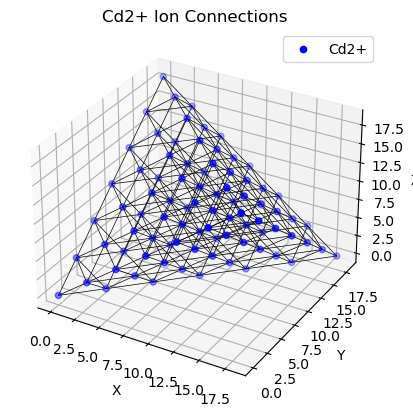

Cd2+ ion at index 0 is at the {'position': 'Edge', 'se_connections': [(1.51292, 1.51292, 1.51292), (1.51292, 4.53876, 4.53876)]}
Cd2+ ion at index 1 is at the {'position': 'Edge', 'se_connections': [(1.51292, 1.51292, 1.51292), (4.53876, 1.51292, 4.53876)]}
Cd2+ ion at index 2 is at the {'position': 'Edge', 'se_connections': [(1.51292, 1.51292, 1.51292), (4.53876, 4.53876, 1.51292)]}
Cd2+ ion at index 3 is at the {'position': 'Face', 'se_connections': [(4.53876, 1.51292, 4.53876), (1.51292, 4.53876, 4.53876), (4.53876, 4.53876, 7.56461)]}
Cd2+ ion at index 4 is at the {'position': 'Face', 'se_connections': [(4.53876, 4.53876, 1.51292), (4.53876, 1.51292, 4.53876), (7.56461, 4.53876, 4.53876)]}
Cd2+ ion at index 5 is at the {'position': 'Face', 'se_connections': [(4.53876, 4.53876, 1.51292), (1.51292, 4.53876, 4.53876), (4.53876, 7.56461, 4.53876)]}
Cd2+ ion at index 6 is at the {'position': 'Edge', 'se_connections': [(1.51292, 4.53876, 4.53876), (1.51292, 7.56461, 7.56461)]}
Cd2+ ion a

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Function to read coordinates from a file and extract Cd2+ and Se2- coordinates
def read_coordinates(file_path):
    cd_coords = []
    se_coords = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            atom_type = parts[0]
            coords = list(map(float, parts[1:4]))
            if atom_type == 'Cd2+':
                cd_coords.append(coords)
            elif atom_type == 'Se2-':
                se_coords.append(coords)
    return cd_coords, se_coords

# Function to calculate the Euclidean distance between two points in 3D space
def euclidean_distance(coord1, coord2):
    return np.sqrt(np.sum((np.array(coord1) - np.array(coord2)) ** 2))

# Function to identify the position of a Cd2+ ion and the Se2- ions it's connected to
def identify_position(cd_coord, se_coords, threshold):
    connections = []
    for se_coord in se_coords:
        if euclidean_distance(cd_coord, se_coord) <= threshold:
            connections.append(tuple(se_coord))  # Store Se2- coordinates as tuples
    num_connections = len(connections)
    
    if num_connections == 1:
        return 'Vertex', connections
    elif num_connections == 2:
        return 'Edge', connections
    elif num_connections == 3:
        return 'Face', connections
    elif num_connections == 4:
        return 'Center', connections
    else:
        return 'Unknown', connections

# Function to count shared neighbors between two Cd atoms
def shared_edge_neighbors(cd_index1, cd_index2, adj_matrix, position_info):
    edge_neighbors1 = {i for i in range(len(adj_matrix)) if adj_matrix[cd_index1, i] == 1 and position_info[i]['position'] == 'Edge'}
    edge_neighbors2 = {i for i in range(len(adj_matrix)) if adj_matrix[cd_index2, i] == 1 and position_info[i]['position'] == 'Edge'}
    
    # Find intersection of edge neighbors
    shared_neighbors = edge_neighbors1.intersection(edge_neighbors2)
    return len(shared_neighbors)

# Read coordinates from the file
cd_coords, se_coords = read_coordinates('/Users/yunyao_1/Dropbox/CdSe-data-owen/cif_xyz_Files/New_cd84se56.xyz')

# Distance thresholds to determine connectivity
cdcd_threshold = 4.4
cdse_threshold = 2.8

# Dictionary to store position information and Se2- connections
position_info = {}

# Identify positions and store in dictionary
for i, cd_coord in enumerate(cd_coords):
    position, se_connections = identify_position(cd_coord, se_coords, cdse_threshold)
    position_info[i] = {'position': position, 'se_connections': se_connections}

# Generate initial adjacency matrix based on Cd2+ coordinates
adj_matrix = np.zeros((len(cd_coords), len(cd_coords)), dtype=int)

for i in range(len(cd_coords)):
    for j in range(i + 1, len(cd_coords)):
        if euclidean_distance(cd_coords[i], cd_coords[j]) <= cdcd_threshold:
            adj_matrix[i, j] = 1
            adj_matrix[j, i] = 1

# Now refine adjacency matrix based on face Cd atoms adjacency criteria
for i in range(len(cd_coords)):
    for j in range(i + 1, len(cd_coords)):
        # Check if both Cd atoms are 'Face' atoms
        if position_info[i]['position'] == 'Face' and position_info[j]['position'] == 'Face':
            # 1. Distance should be less than the threshold (already checked)
            if adj_matrix[i, j] == 1:
                # 2. They should not share more than one neighbor at the "Edge"
                if shared_edge_neighbors(i, j, adj_matrix, position_info) > 1:
                    # If they share more than one edge neighbor, remove adjacency
                    adj_matrix[i, j] = 0
                    adj_matrix[j, i] = 0

print("Refined Adjacency Matrix:")
print(adj_matrix)

from mpl_toolkits.mplot3d import Axes3D

# Convert lists to numpy arrays for easier manipulation
cd_coords = np.array(cd_coords)

# Plotting the Cd2+ ions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cd_coords[:, 0], cd_coords[:, 1], cd_coords[:, 2], c='b', label='Cd2+')

# Adding edges between connected Cd2+ ions based on adjacency matrix
for i in range(len(cd_coords)):
    for j in range(i + 1, len(cd_coords)):
        if adj_matrix[i, j] == 1:
            ax.plot([cd_coords[i, 0], cd_coords[j, 0]], 
                    [cd_coords[i, 1], cd_coords[j, 1]], 
                    [cd_coords[i, 2], cd_coords[j, 2]], 'k-', lw=0.5)

# Labels and view settings
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Cd2+ Ion Connections')
plt.legend()
plt.show()

# Count edge and face atoms
edge_count = sum(1 for info in position_info.values() if info['position'] == 'Edge')
face_count = sum(1 for info in position_info.values() if info['position'] == 'Face')

# Output position information
for cd_index, info in position_info.items():
    print(f"Cd2+ ion at index {cd_index} is at the {info}")

# Output counts
print(f"{edge_count} of edge atoms, {face_count} of face atoms")


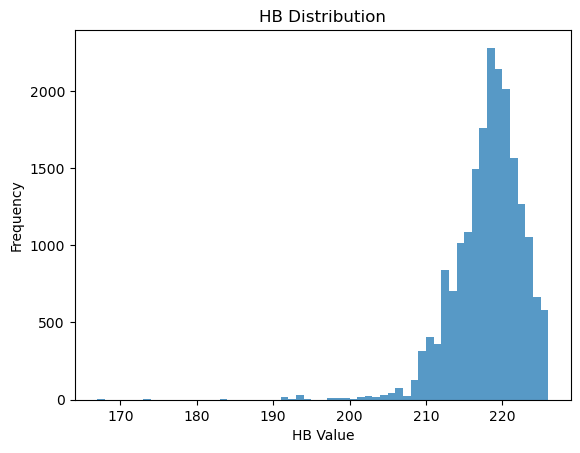

The best configuration has an HB value of 226:
Cd2+ ion at index 0 has ligands: ['A', 'B']
Cd2+ ion at index 1 has ligands: ['B', 'A']
Cd2+ ion at index 2 has ligands: ['A', 'B']
Cd2+ ion at index 3 has ligands: ['A']
Cd2+ ion at index 4 has ligands: ['A']
Cd2+ ion at index 5 has ligands: ['A']
Cd2+ ion at index 6 has ligands: ['A', 'B']
Cd2+ ion at index 7 has ligands: ['B', 'A']
Cd2+ ion at index 8 has ligands: ['B', 'A']
Cd2+ ion at index 9 has ligands: []
Cd2+ ion at index 10 has ligands: ['B']
Cd2+ ion at index 11 has ligands: ['B']
Cd2+ ion at index 12 has ligands: ['B']
Cd2+ ion at index 13 has ligands: ['B']
Cd2+ ion at index 14 has ligands: ['A']
Cd2+ ion at index 15 has ligands: ['B']
Cd2+ ion at index 16 has ligands: ['B', 'A']
Cd2+ ion at index 17 has ligands: ['B', 'A']
Cd2+ ion at index 18 has ligands: ['B', 'A']
Cd2+ ion at index 19 has ligands: []
Cd2+ ion at index 20 has ligands: []
Cd2+ ion at index 21 has ligands: []
Cd2+ ion at index 22 has ligands: ['A']
Cd2+ ion a

In [5]:

# Function to calculate HB
def calculate_HB(assignments, adj_matrix):
    HB = 0
    num_cd = len(assignments)
    for i in range(num_cd):
        # Increase HB for each A-B pair at the same Cd atom
        if 'A' in assignments[i] and 'B' in assignments[i]:
            HB += 1
        # Increase HB for each A-B pair in adjacent Cd atoms
        for j in range(i + 1, num_cd):
            if adj_matrix[i, j] == 1:
                if ('A' in assignments[i] and 'B' in assignments[j]) or ('B' in assignments[i] and 'A' in assignments[j]):
                    HB += 1
    return HB


# Monte Carlo simulation parameters
num_A = 56
num_B = 56
num_iterations = 20000

# Initialize Cd vertices with the appropriate number of ligands
assignments = [[] for _ in range(len(cd_coords))]

# Populate the initial assignments
ligand_counts = {
    'Vertex': 3,
    'Edge': 2,
    'Face': 1,
    'Center': 0
}

# Assign ligands ensuring each type follows the specified constraints
ligands = ['A'] * num_A + ['B'] * num_B
random.shuffle(ligands)
ligand_index = 0

for i in range(len(cd_coords)):
    pos = position_info[i]['position']
    count = ligand_counts[pos]
    assignments[i] = ligands[ligand_index:ligand_index + count]
    ligand_index += count

# Initial HB calculation
current_HB = calculate_HB(assignments, adj_matrix)
HB_distribution = []

best_HB = current_HB
best_assignments = [list(assignment) for assignment in assignments]

# Monte Carlo simulation
for iteration in range(num_iterations):
    # Randomly pick two vertices to swap ligands
    v1, v2 = random.sample(range(len(cd_coords)), 2)
    
    # Ensure both vertices have ligands to swap
    if len(assignments[v1]) > 0 and len(assignments[v2]) > 0:
        # Randomly pick a ligand from each vertex
        ligand_v1 = random.choice(assignments[v1])
        ligand_v2 = random.choice(assignments[v2])
        
        # Swap ligands
        assignments[v1].remove(ligand_v1)
        assignments[v1].append(ligand_v2)
        assignments[v2].remove(ligand_v2)
        assignments[v2].append(ligand_v1)
        
        # Calculate new HB
        new_HB = calculate_HB(assignments, adj_matrix)
        
        # Accept or reject the swap based on the Metropolis criterion
        if new_HB >= current_HB or random.uniform(0, 1) < np.exp(new_HB - current_HB):
            current_HB = new_HB
            # Update the best configuration if the new HB is higher
            if new_HB > best_HB:
                best_HB = new_HB
                best_assignments = [list(assignment) for assignment in assignments]
        else:
            # Revert the swap
            assignments[v1].remove(ligand_v2)
            assignments[v1].append(ligand_v1)
            assignments[v2].remove(ligand_v1)
            assignments[v2].append(ligand_v2)
    
    # Record HB
    HB_distribution.append(current_HB)

# Plot HB distribution
plt.hist(HB_distribution, bins=range(min(HB_distribution), max(HB_distribution) + 1), alpha=0.75)
plt.xlabel('HB Value')
plt.ylabel('Frequency')
plt.title('HB Distribution')
plt.show()

# Output the best configuration
print(f"The best configuration has an HB value of {best_HB}:")
for i, assignment in enumerate(best_assignments):
    print(f"Cd2+ ion at index {i} has ligands: {assignment}")
    



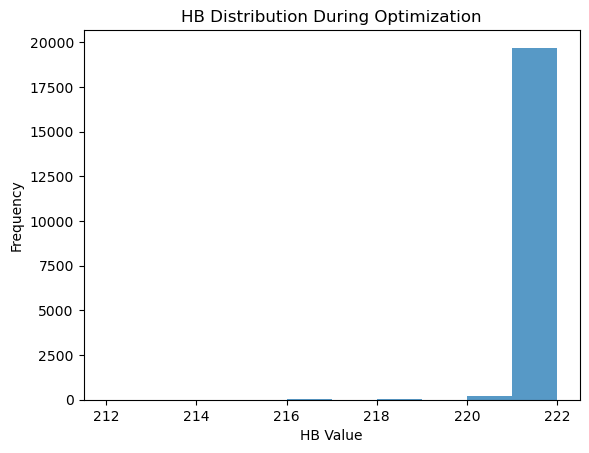

The best configuration has an HB value of 222:
Cd2+ ion at index 0 has ligands: ['A', 'B']
Cd2+ ion at index 1 has ligands: ['A', 'B']
Cd2+ ion at index 2 has ligands: ['A', 'B']
Cd2+ ion at index 3 has ligands: ['A']
Cd2+ ion at index 4 has ligands: ['B']
Cd2+ ion at index 5 has ligands: ['A']
Cd2+ ion at index 6 has ligands: ['A', 'B']
Cd2+ ion at index 7 has ligands: ['A', 'B']
Cd2+ ion at index 8 has ligands: ['A', 'B']
Cd2+ ion at index 9 has ligands: []
Cd2+ ion at index 10 has ligands: ['A']
Cd2+ ion at index 11 has ligands: ['B']
Cd2+ ion at index 12 has ligands: ['B']
Cd2+ ion at index 13 has ligands: ['A']
Cd2+ ion at index 14 has ligands: ['B']
Cd2+ ion at index 15 has ligands: ['A']
Cd2+ ion at index 16 has ligands: ['A', 'B']
Cd2+ ion at index 17 has ligands: ['A', 'B']
Cd2+ ion at index 18 has ligands: ['A', 'B']
Cd2+ ion at index 19 has ligands: []
Cd2+ ion at index 20 has ligands: []
Cd2+ ion at index 21 has ligands: []
Cd2+ ion at index 22 has ligands: ['A']
Cd2+ ion a

In [8]:
# calcualte experiment model HB
import random
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate HB
def calculate_HB(assignments, adj_matrix):
    HB = 0
    num_cd = len(assignments)
    for i in range(num_cd):
        if 'A' in assignments[i] and 'B' in assignments[i]:
            HB += 1
        for j in range(i + 1, num_cd):
            if adj_matrix[i, j] == 1:
                if ('A' in assignments[i] and 'B' in assignments[j]) or ('B' in assignments[i] and 'A' in assignments[j]):
                    HB += 1
    return HB

# Monte Carlo simulation parameters
num_A = 56  # 56 A ligands
num_B = 56  # 56 B ligands
num_iterations = 20000

# Initialize Cd vertices with the appropriate number of ligands based on new rules
assignments = [[] for _ in range(len(cd_coords))]

# Step 1: Fixed assignments for Vertex, Edge, and Center
for i in range(len(cd_coords)):
    pos = position_info[i]['position']
    
    if pos == 'Vertex':
        # Assign 3 'A' ligands to all vertex positions
        assignments[i] = ['A', 'A', 'A']
        num_A -= 3  # Reduce count of A ligands
    
    elif pos == 'Edge':
        # Assign 1 'A' and 1 'B' ligand to all edge positions
        assignments[i] = ['A', 'B']
        num_A -= 1  # Reduce count of A ligands
        num_B -= 1  # Reduce count of B ligands
    
    elif pos == 'Center':
        # No ligands for center positions
        assignments[i] = []

# Step 2: Initialize ligands for face positions with either 'A' or 'B' randomly
face_indices = [i for i in range(len(cd_coords)) if position_info[i]['position'] == 'Face']

# Randomly distribute the remaining 'A' and 'B' ligands among face positions
remaining_ligands = ['A'] * num_A + ['B'] * num_B
random.shuffle(remaining_ligands)

for i, face_idx in enumerate(face_indices):
    assignments[face_idx] = [remaining_ligands[i]]

# Initial HB calculation
current_HB = calculate_HB(assignments, adj_matrix)
HB_distribution = []

best_HB = current_HB
best_assignments = [list(assignment) for assignment in assignments]

# Monte Carlo simulation to optimize face assignments
temperature = 1.0  # Initial temperature for simulated annealing
cooling_rate = 0.999  # Cooling rate to reduce temperature

for iteration in range(num_iterations):
    # Randomly pick one face position to swap its ligand
    face_idx = random.choice(face_indices)
    
    # Current ligand on the selected face position
    current_ligand = assignments[face_idx][0]
    
    # Swap the ligand ('A' -> 'B' or 'B' -> 'A')
    new_ligand = 'B' if current_ligand == 'A' else 'A'
    assignments[face_idx] = [new_ligand]
    
    # Calculate new HB
    new_HB = calculate_HB(assignments, adj_matrix)
    
    # Accept or reject the swap based on the Metropolis criterion
    if new_HB >= current_HB or random.uniform(0, 1) < np.exp((new_HB - current_HB) / temperature):
        current_HB = new_HB
        if new_HB > best_HB:
            best_HB = new_HB
            best_assignments = [list(assignment) for assignment in assignments]
    else:
        # Revert the swap
        assignments[face_idx] = [current_ligand]
    
    # Cooling the temperature
    temperature *= cooling_rate
    
    # Record HB
    HB_distribution.append(current_HB)

# Plot HB distribution
plt.hist(HB_distribution, bins=range(min(HB_distribution), max(HB_distribution) + 1), alpha=0.75)
plt.xlabel('HB Value')
plt.ylabel('Frequency')
plt.title('HB Distribution During Optimization')
plt.show()

# Output the best configuration and HB value
print(f"The best configuration has an HB value of {best_HB}:")
for i, assignment in enumerate(best_assignments):
    print(f"Cd2+ ion at index {i} has ligands: {assignment}")



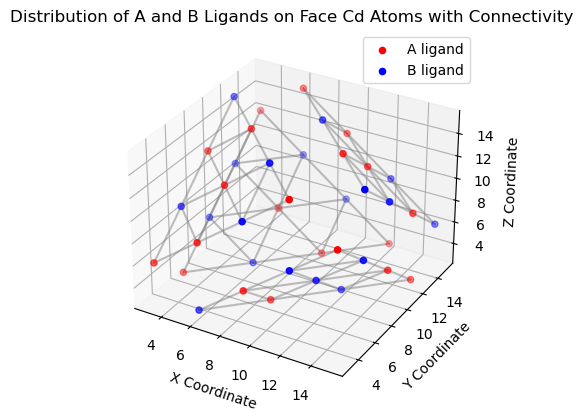

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming that `best_assignments` contains the final ligand assignments after optimization
# and `position_info` contains the position information (Vertex, Edge, Face, etc.)
# Also assuming that `adj_matrix` contains the adjacency matrix

# Extract the face Cd coordinates and their ligand types
face_coords = []
face_ligands = []
face_indices = []

for i in range(len(cd_coords)):
    if position_info[i]['position'] == 'Face':
        face_coords.append(cd_coords[i])  # Store the coordinate of the face Cd
        face_ligands.append(best_assignments[i][0])  # Store the ligand ('A' or 'B') on that Cd
        face_indices.append(i)  # Store the index of the face Cd

face_coords = np.array(face_coords)  # Convert list to numpy array for easier manipulation

# Separate the face atoms into two lists based on their ligand type
face_A_coords = face_coords[np.array(face_ligands) == 'A']
face_B_coords = face_coords[np.array(face_ligands) == 'B']

# Plot the distribution of ligands on the face atoms
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot face Cd atoms with 'A' ligands in red and 'B' ligands in blue
ax.scatter(face_A_coords[:, 0], face_A_coords[:, 1], face_A_coords[:, 2], c='red', label='A ligand')
ax.scatter(face_B_coords[:, 0], face_B_coords[:, 1], face_B_coords[:, 2], c='blue', label='B ligand')

# Link adjacent face Cd atoms with lines
for i in range(len(face_indices)):
    for j in range(i + 1, len(face_indices)):
        idx_i = face_indices[i]
        idx_j = face_indices[j]
        if adj_matrix[idx_i, idx_j] == 1:  # Check if Cd atoms i and j are adjacent
            # Draw a line between the adjacent Cd atoms
            x_vals = [cd_coords[idx_i][0], cd_coords[idx_j][0]]
            y_vals = [cd_coords[idx_i][1], cd_coords[idx_j][1]]
            z_vals = [cd_coords[idx_i][2], cd_coords[idx_j][2]]
            ax.plot(x_vals, y_vals, z_vals, c='gray', alpha=0.5)

# Set labels and title
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('Distribution of A and B Ligands on Face Cd Atoms with Connectivity')

# Add a legend
ax.legend()

# Show the plot
plt.show()

